In [157]:
pip install mysql-connector-python
pip install selenium

SyntaxError: invalid syntax (<ipython-input-157-8f5932c1b604>, line 1)

In [158]:
import mysql.connector
import warnings
import requests
import json
import codecs
import time
import os.path
import re
import math
from bs4 import BeautifulSoup
from selenium import webdriver
import matplotlib.pyplot as plt
from selenium.webdriver.common.keys import Keys
import pandas as pd
import numpy as np

#ignore warnings
warnings.filterwarnings("ignore")

In [18]:
SQL_DB = "msba"
SQL_TABLE_IPAdd = "ip_addresses"
SQL_TABLE_IPAdd_DEF = "(" + \
            "id INT NOT NULL AUTO_INCREMENT PRIMARY KEY" + \
            ",ip VARCHAR(15)" + \
            ",city VARCHAR(1000)" + \
            ",zip VARCHAR(15)" + \
            ")"

try:
    #connect to server
    conn = mysql.connector.connect(host='localhost',
                                            user='root',
                                            password='771990', auth_plugin='mysql_native_password')
    cursor = conn.cursor()

    query = "CREATE DATABASE IF NOT EXISTS " + SQL_DB
    print(query)
    cursor.execute(query);
    query = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE_IPAdd + " " + SQL_TABLE_IPAdd_DEF + ";";
    print(query)
    cursor.execute(query);
    cursor.close()
    conn.close()
except IOError as e:
    print(e)

CREATE DATABASE IF NOT EXISTS msba
CREATE TABLE IF NOT EXISTS msba.ip_addresses (id INT NOT NULL AUTO_INCREMENT PRIMARY KEY,ip VARCHAR(15),city VARCHAR(1000),zip VARCHAR(15));


In [16]:
AccessKey = "ccbd1754d966f9a890af29b71de84bbe"

URLS = ["http://api.ipstack.com/8.8.8.8?access_key="+AccessKey,"http://api.ipstack.com/128.120.0.25?access_key="+AccessKey,"http://api.ipstack.com/128.32.12.14?access_key="+AccessKey,"http://api.ipstack.com/64.165.72.144?access_key="+AccessKey,"http://api.ipstack.com/24.4.73.72?access_key="+AccessKey]
responses = []

for i in range(0,5):
    try:
        page = requests.get(URLS[i])   
        time.sleep(10)
        doc = BeautifulSoup(page.content, 'html.parser')        
        json_dict = json.loads(str(doc))
        json_formatted_str = json.dumps(json_dict, indent=2)
        print("JSON Object-"+ str(i+1))
        print(json_formatted_str)
        print("\n")
        responses.append(json_dict)
    
    except IOError as e:        
        print(e)

JSON Object-0
{
  "ip": "8.8.8.8",
  "type": "ipv4",
  "continent_code": "NA",
  "continent_name": "North America",
  "country_code": "US",
  "country_name": "United States",
  "region_code": "CA",
  "region_name": "California",
  "city": "Mountain View",
  "zip": "94041",
  "latitude": 37.38801956176758,
  "longitude": -122.07431030273438,
  "location": {
    "geoname_id": 5375480,
    "capital": "Washington D.C.",
    "languages": [
      {
        "code": "en",
        "name": "English",
        "native": "English"
      }
    ],
    "country_flag": "http://assets.ipstack.com/flags/us.svg",
    "country_flag_emoji": "\ud83c\uddfa\ud83c\uddf8",
    "country_flag_emoji_unicode": "U+1F1FA U+1F1F8",
    "calling_code": "1",
    "is_eu": false
  }
}


JSON Object-1
{
  "ip": "128.120.0.25",
  "type": "ipv4",
  "continent_code": "NA",
  "continent_name": "North America",
  "country_code": "US",
  "country_name": "United States",
  "region_code": "CA",
  "region_name": "California",
  "cit

KeyboardInterrupt: 

In [17]:
for r in responses:
    print("City: "+str(r["city"])+ " Zip: "+str(r["zip"]))

City: Mountain View Zip: 94041
City: Davis Zip: 95616
City: Berkeley Zip: 94720


In [19]:
def insert_into_table(ip,city,zipcode): 
    try:
        #connect to server
        conn = mysql.connector.connect(host='localhost',
                                            database='msba',
                                            user='root',
                                            password='771990')
        cursor = conn.cursor()        
        parameterized_stmt = "INSERT INTO " + SQL_TABLE_IPAdd + " (ip,city,zip) values (%s,%s,%s);"
        cursor.execute(parameterized_stmt, (ip,city,zipcode))
        conn.commit()
        cursor.close()
        conn.close() 
        
    except IOError as e:
        print(e)
        
for r in responses:
    insert_into_table(str(r["ip"]),str(r["city"]),str(r["zip"]))

In [20]:
EBAYURL = "https://www.ebay.com/e/daily-deals/hiw-presidents-day-deals-white-sale?_pgn="

def write_to_text(URL):
    try:
        user_agent = {'User-agent': 'Mozilla/5.0'} 
        page = requests.get(URL, user_agent)
        doc = BeautifulSoup(page.content, "html.parser")
        list_of_spon_items = doc.find_all("div", {"class":"s-item__info clearfix"})
        for p in list_of_spon_items:
            spon_parent = p.findNext('a')
            url1 = str(spon_parent['href'])
            with open("deals.txt", "a", encoding="utf-8") as f:
                f.write(url1+"\n")
    
    except IOError as e:
        print(e)


for i in range(1,11):
    URL = EBAYURL +str(i)
    write_to_text(URL)
    time.sleep(5)

In [21]:
f= open('deals.txt', 'r').read()
lines = f.split('\n')
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, r'deals')
if not os.path.exists(final_directory):
    os.makedirs(final_directory)
for l in range(0,len(lines)):
    try:
        user_agent = {'User-agent': 'Mozilla/5.0'} 
        url3 = lines[l]
        page = requests.get(url3, user_agent)
        doc = BeautifulSoup(page.content, "html.parser")
        ItemId = re.sub(r'.+/(\d{12}).+', r'\1', url3)
        with open(os.path.join(final_directory, str(ItemId) + '.html'), 'w', encoding="utf-8") as file:
            file.write(str(doc))
        time.sleep(5)
    except Exception:
        pass

In [39]:
downloaded_pages = os.listdir('./deals')
page_objs = pd.DataFrame(columns = ['seller_name', 'seller_score', 'item_price','list_price', 'no_of_items_sold', 'title', 'returns_allowed', 'shipping_price', 'item_condition'])
i = 0
for page in downloaded_pages:
    readfile = open(os.path.join(final_directory, page), 'r', encoding="utf8").read()
    doc3d = BeautifulSoup(readfile, 'html.parser')
    
    
## Getting seller name
    try:
        find_seller = doc3d.find('div', class_ = 'mbg vi-VR-margBtm3') ## selector command
        seller_name = find_seller.find('span', class_ = 'mbg-nw').get_text() ## selector command
    except:
        seller_name = None


## Getting the seller score
    try:
        seller_score = int(find_seller.find('span', class_ = 'mbg-l').find('a').get_text()) ## selector command
    except:
        seller_score = None


## Getting the item price
    try:
        find_price = doc3d.find('span', id = 'prcIsum').get_text() ## selector command
        item_price = pd.to_numeric(re.sub(r'.*\$([.\d]+).*', r'\1', find_price))
    except:
        item_price = None
        
## Getting item list price
    try:
        find_list_price = doc3d.find('span', id = 'orgPrc').get_text()  ## selector command
        list_price = pd.to_numeric(re.findall(r'\d*\.?\d+', find_list_price)[0])
    except:
        list_price = None

        
## Getting number of items sold
#     try:
#         try:
#             sold = doc3d.find('a', class_ = 'vi-txt-underline').get_text() ## selector command
#         except:
#             sold = doc3d.find('div', class_ = 'w2b-cnt w2b-3 w2b-red').get_text() ## selector command
#             sold2 = doc3d.find('div', class_ = 'w2b-cnt w2b-3 w2b-brdr').get_text() ## selector command
#             sold_num = re.findall(r'([^\s]+)', sold)[0]
#             no_of_items_sold = pd.to_numeric(re.sub(r',', r'', sold_num))
#     except:
#         no_of_items_sold = None
        
## Getting number of items sold        
    try:
        find_item = doc3d.find('div', class_ = 'nonActPanel') ## selector command
        sold = find_item.find('a', class_ = 'vi-txt-underline').get_text() ## selector command
        sold_num = re.sub(r'([,\d]+) sold', r'\1', sold)
        no_of_items_sold = pd.to_numeric(re.sub(r',', r'', sold_num))
    except:
        no_of_items_sold = None        
        

## Item title
    try:
        title_text = doc3d.find('h1', id = 'itemTitle').get_text() ## selector command
        title = re.sub(r'.+\xa0', r'', title_text)
    except:
        title = None
    
    
## Find whether returns allowed(True or False)
    try:
        find_returns = doc3d.find('span', id = 'vi-ret-accrd-txt').get_text() ## selector command
        if find_returns == 'Seller does not accept returns':
            returns_allowed = 'No'
        else:
            returns_allowed = 'Yes'
    except:
        returns_allowed = None

        
## Get item shipping cost
    try:
        try:
            find_shipping_price = doc3d.find('span', id = 'convetedPriceId').get_text() ## selector command
            shipping_price = pd.to_numeric(re.sub(r'[$\nUS]', r'', find_shipping_price))
        except:
            try:
                find_shipping_price = doc3d.find('span', id = 'fshippingCost').get_text() ## selector command
                try:
                    shipping_price = pd.to_numeric(re.sub(r'[$\n]', r'', find_shipping_price))
                except:
                    shipping_price = re.sub(r'[$\n]', r'', find_shipping_price)
            except:
                find_shipping_price = doc3d.find('span', id = 'shSummary').get_text() ## selector command
                try:
                    shipping_price = re.findall(r"FAST 'N FREE", find_shipping_price)[0]
                except:
                    try:
                        shipping_price = re.findall(r"Local pick-up offered.", find_shipping_price)[0]
                    except:
                        try:
                            shipping_price = re.sub(r'\n', r'', doc3d.find('span', id = 'fShippingSvc').get_text()) ## selector command
                        except:
                            shipping_price = doc3d.find('a', id = 'e3').get_text() ## selector command    
    except:
        shipping_price = None
    
## Item condition
    try:
        item_condition = doc3d.find('div', id = 'vi-itm-cond').get_text() ## selector command
    except:
        item_condition = None

## Saving to data frame
    page_objs.loc[i] = [seller_name, seller_score, item_price, list_price, no_of_items_sold, title, returns_allowed, shipping_price, item_condition]
#     print(str(i))
#     print()
#     print(page_objs.loc[i])
#     print()
    i = i + 1

In [40]:
# Converting shipping price to 0 wherever FREE delivery
page_objs['shipping_price'] = np.where(page_objs['shipping_price'] == "FAST 'N FREE", 0, page_objs['shipping_price'])
page_objs['shipping_price'] = np.where(page_objs['shipping_price'] == 'FREE', 0, page_objs['shipping_price'])
page_objs['shipping_price'] = np.where(page_objs['shipping_price'] == 'Calculate', None, page_objs['shipping_price'])
page_objs['shipping_price'] = np.where(page_objs['shipping_price'] == 'Local pick-up offered.', 0, page_objs['shipping_price'])
page_objs['shipping_price'] = np.where(page_objs['shipping_price'] == 'Free Local Pickup', 0, page_objs['shipping_price'])

In [47]:
# View complete table
page_objs

,seller_name,seller_score,item_price,list_price,no_of_items_sold,title,returns_allowed,shipping_price,item_condition
0,cozyarray,219888,7.99,16.99,2786,SET OF 1500 TC PILLOWCASES TWO PILLOW CASES PE...,Yes,0,New with tags
1,cozyarray,219887,7.99,17.99,14862,1200 SERIES PILLOWCASES - 2 Pillow Cases Per S...,Yes,0,New with tags
2,cozyarray,219889,21.99,79.99,14504,1800 Count 4 Piece Deep Pocket Bed Sheet Set -...,Yes,0,New with tags
3,cozyarray,219888,5.99,29.99,4192,Bedskirt Pins - Set of 8 Plastic Head Bed Skir...,Yes,0,New with tags
4,cozyarray,219886,5.99,29.99,27874,1800 Pillow Case Set Standard or King Ultra So...,Yes,0,New with tags
...,...,...,...,...,...,...,...,...,...
91,ecitydirect,99656,78.99,None,570,Chezmoi Collection Seville 9-piece Jacquard Pa...,Yes,0,New with tags
92,linenspa,22158,49.99,None,5018,"LUCID 2, 3, 4 Inch Cooling Gel Memory Foam Mat...",Yes,0,New with tags
93,linenspa,22159,39.99,None,1040,LUCID 2-inch 5 Zone Gel or Lavender Scented Me...,Yes,0,New with tags
94,linenspa,22158,52.99,None,1325,"Linenspa 2, 3, 4 inch Soft Plush Swirl Gel Mem...",Yes,0,New with tags


In [48]:
SQL_DB = "msba"
SQL_TABLE_Deals = "deals"
SQL_TABLE_Deals_DEF = "(" + \
            "seller_name VARCHAR(255)" + \
            ",seller_score INT" + \
            ",item_price INT" + \
            ",list_price INT" + \
            ",no_of_items_sold INT" + \
            ",title VARCHAR(255)" + \
            ",returns_allowed VARCHAR(255)" + \
            ",shipping_price INT" + \
            ",item_condition VARCHAR(255)" + \
            ")"
try:
    #connect to server
    conn = mysql.connector.connect(host='localhost',
                                            user='root',
                                            password='771990', auth_plugin='mysql_native_password')
    cursor = conn.cursor()

    query = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE_Deals + " " + SQL_TABLE_Deals_DEF + ";";
    print(query)
    cursor.execute(query);
    cursor.close()
    conn.close()

except IOError as e:
    print(e)

CREATE TABLE IF NOT EXISTS msba.deals (seller_name VARCHAR(255),seller_score INT,item_price INT,list_price INT,no_of_items_sold INT,title VARCHAR(255),returns_allowed VARCHAR(255),shipping_price INT,item_condition VARCHAR(255));


In [49]:
for p in page_objs.index:
    
    ## Changing item_price to cents
    try:
        item_price = int(page_objs['item_price'][p] * 100)
    except:
        item_price = None
    
    ## Change list_price to cents
    try:
        list_price = int(page_objs['list_price'][p] * 100)
    except:
        list_price = None

    ## Change shipping_price to cents
    try:
        shipping_price = int(page_objs['shipping_price'][p] * 100)
    except:
        shipping_price = None
        
    ## Insert data into table 'Deals'
    try:
        #connect to server
        conn = mysql.connector.connect(host='localhost',
                                            database='msba',
                                            user='root',
                                            password='771990')
        cursor = conn.cursor()        
        parameterized_stmt = "INSERT INTO " + SQL_TABLE_Deals + " (seller_name, seller_score ,item_price,list_price,no_of_items_sold,title,returns_allowed,shipping_price,item_condition) values (%s,%s,%s,%s,%s,%s,%s,%s,%s)"
        val = (page_objs['seller_name'][p], page_objs['seller_score'][p], item_price,list_price, page_objs['no_of_items_sold'][p],page_objs['title'][p], page_objs['returns_allowed'][p], shipping_price, page_objs['item_condition'][p])
        cursor.execute(parameterized_stmt, val)
        conn.commit()
        cursor.close()
        conn.close()

    except IOError as e:
        print(e)    
    

In [50]:
## Using 0-1 conversion for the list price categorical column 

page_objs['list_price'] = np.where(page_objs['list_price'] > 0, "Yes", "No")

## Use 0-1 conversion for the 'returns_allowed' categorical column to get total count of items where returns were allowed
page_objs['returns_allowed'] = np.where(page_objs['returns_allowed'] == 'Yes', 1, page_objs['returns_allowed'])
page_objs['returns_allowed'] = np.where(page_objs['returns_allowed'] == 'No', 0, page_objs['returns_allowed'])

## Converting data points to numerical values
page_objs['seller_score'] = pd.to_numeric(page_objs['seller_score'])
page_objs['no_of_items_sold'] = pd.to_numeric(page_objs['no_of_items_sold'])
page_objs['item_price'] = pd.to_numeric(page_objs['item_price'])
page_objs['shipping_price'] = pd.to_numeric(page_objs['shipping_price'])

## Build a summary table structure
summaryTab = page_objs[['list_price', 'item_condition', 'item_price']].groupby(['list_price', 'item_condition'], as_index = False).mean()
summaryTab = summaryTab.drop('item_price', 1)

## Summary stats for each numerical column
numerical = ['seller_score', 'item_price', 'no_of_items_sold','shipping_price']

for i in numerical:
    col_mean = page_objs[['list_price', 'item_condition', i]].groupby(['list_price', 'item_condition'], as_index = False).mean()
    col_mean.rename(columns = {i: 'mean_' + i}, inplace = True)

    col_min = page_objs[['list_price', 'item_condition', i]].groupby(['list_price', 'item_condition'], as_index = False).min()
    col_min.rename(columns = {i: 'min_' + i}, inplace = True)

    col_max = page_objs[['list_price', 'item_condition', i]].groupby(['list_price', 'item_condition'], as_index = False).max()
    col_max.rename(columns = {i: 'max_' + i}, inplace = True)
    
    summaryTab = pd.merge(summaryTab, col_mean, on = ['list_price', 'item_condition'])
    summaryTab = pd.merge(summaryTab, col_min, on = ['list_price', 'item_condition'])
    summaryTab = pd.merge(summaryTab, col_max, on = ['list_price', 'item_condition'])

summaryTab

,list_price,item_condition,mean_seller_score,min_seller_score,max_seller_score,mean_item_price,min_item_price,max_item_price,mean_no_of_items_sold,min_no_of_items_sold,max_no_of_items_sold
0,No,New with tags,49320.907407,11454,146980,24.937000,7.99,78.99,1912.462963,3.0,6979.0
1,Yes,New,68417.750000,65498,77177,33.740000,9.99,94.99,10939.000000,1865.0,28135.0
2,Yes,New with tags,202645.500000,3196,219889,19.173421,5.99,59.99,13494.289474,125.0,181436.0


In [53]:
## Count of each level for non numerical columns
factors = ['seller_name', 'title', 'returns_allowed']
for i in factors:
    col_count = page_objs[['list_price', 'item_condition', i]].groupby(['list_price', 'item_condition'], as_index = False).count()
    col_count.rename(columns={i: 'count_' + i}, inplace = True)
    
    summaryTab = pd.merge(summaryTab, col_count, on = ['list_price', 'item_condition'])

summaryTab

,list_price,item_condition,mean_seller_score,min_seller_score,max_seller_score,mean_item_price,min_item_price,max_item_price,mean_no_of_items_sold,min_no_of_items_sold,max_no_of_items_sold,count_seller_name,count_title,count_returns_allowed
0,No,New with tags,49320.907407,11454,146980,24.937000,7.99,78.99,1912.462963,3.0,6979.0,54,54,54
1,Yes,New,68417.750000,65498,77177,33.740000,9.99,94.99,10939.000000,1865.0,28135.0,4,4,4
2,Yes,New with tags,202645.500000,3196,219889,19.173421,5.99,59.99,13494.289474,125.0,181436.0,38,38,38


In [78]:
page_objs

,seller_name,seller_score,item_price,list_price,no_of_items_sold,title,returns_allowed,shipping_price,item_condition
0,cozyarray,219888,7.99,Yes,2786.0,SET OF 1500 TC PILLOWCASES TWO PILLOW CASES PE...,1,0,New with tags
1,cozyarray,219887,7.99,Yes,14862.0,1200 SERIES PILLOWCASES - 2 Pillow Cases Per S...,1,0,New with tags
2,cozyarray,219889,21.99,Yes,14504.0,1800 Count 4 Piece Deep Pocket Bed Sheet Set -...,1,0,New with tags
3,cozyarray,219888,5.99,Yes,4192.0,Bedskirt Pins - Set of 8 Plastic Head Bed Skir...,1,0,New with tags
4,cozyarray,219886,5.99,Yes,27874.0,1800 Pillow Case Set Standard or King Ultra So...,1,0,New with tags
...,...,...,...,...,...,...,...,...,...
91,ecitydirect,99656,78.99,No,570.0,Chezmoi Collection Seville 9-piece Jacquard Pa...,1,0,New with tags
92,linenspa,22158,49.99,No,5018.0,"LUCID 2, 3, 4 Inch Cooling Gel Memory Foam Mat...",1,0,New with tags
93,linenspa,22159,39.99,No,1040.0,LUCID 2-inch 5 Zone Gel or Lavender Scented Me...,1,0,New with tags
94,linenspa,22158,52.99,No,1325.0,"Linenspa 2, 3, 4 inch Soft Plush Swirl Gel Mem...",1,0,New with tags


In [125]:
#Getting distinct values of list_price
page_objs.list_price.unique()

array(['Yes', 'No'], dtype=object)

In [126]:
#Getting distinct values of item_conditions
page_objs.item_condition.unique()

array(['New with tags', 'New'], dtype=object)

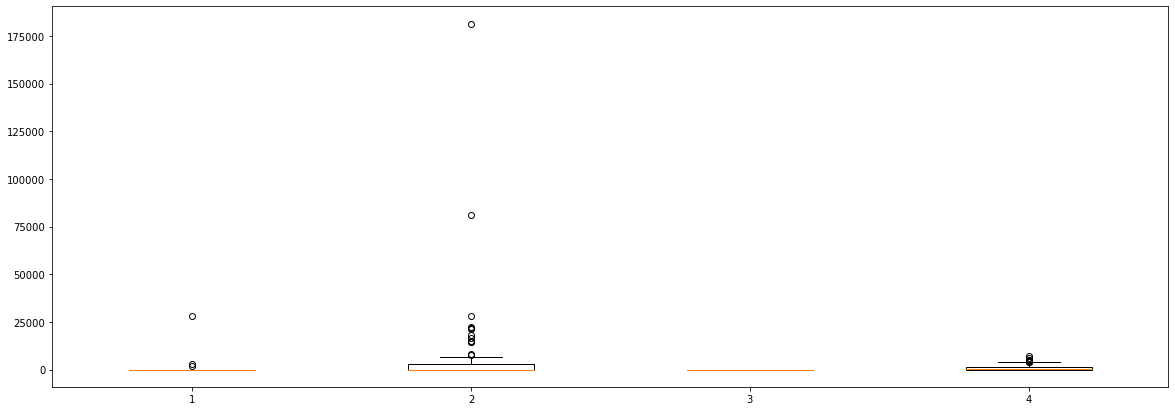

In [155]:
listprice_New = []
listprice_New_tags = []
No_listprice_New = []
No_listprice_New_tags = []

i = 0
while i < len(page_objs):
    if page_objs["list_price"].tolist()[i] == "Yes" and page_objs["item_condition"].tolist()[i] == "New":
        listprice_New.append(page_objs["no_of_items_sold"].tolist()[i]) if not math.isnan(page_objs["no_of_items_sold"].tolist()[i]) else listprice_New.append(0)
    else:
        listprice_New.append(0)
    
    if page_objs["list_price"].tolist()[i] == "Yes" and page_objs["item_condition"].tolist()[i] == "New with tags":
        listprice_New_tags.append(page_objs["no_of_items_sold"].tolist()[i]) if not math.isnan(page_objs["no_of_items_sold"].tolist()[i]) else listprice_New_tags.append(0)
    else:
        listprice_New_tags.append(0)
        
    if page_objs["list_price"].tolist()[i] == "No" and page_objs["item_condition"].tolist()[i] == "New":
        No_listprice_New.append(page_objs["no_of_items_sold"].tolist()[i]) if not math.isnan(page_objs["no_of_items_sold"].tolist()[i]) else No_listprice_New.append(0)
    else:
        No_listprice_New.append(0)

    if page_objs["list_price"].tolist()[i] == "No" and page_objs["item_condition"].tolist()[i] == "New with tags":
        No_listprice_New_tags.append(page_objs["no_of_items_sold"].tolist()[i]) if not math.isnan(page_objs["no_of_items_sold"].tolist()[i]) else No_listprice_New_tags.append(0)
    else:
        No_listprice_New_tags.append(0)
     
    i = i+1
    
StatsTab = []

StatsTab.append(listprice_New)
StatsTab.append(listprice_New_tags)
StatsTab.append(No_listprice_New)
StatsTab.append(No_listprice_New_tags)

# StatsTab

fig = plt.figure(1, figsize=(20, 7))
# plt.xticks([1, 2, 3, 4],['listprice_New', 'listprice_New_tags', 'No_listprice_New','No_listprice_New_tags'])
plt.boxplot(StatsTab)
# StatsTab.boxplot(column = ['listprice_New', 'listprice_New_tags', 'No_listprice_New','No_listprice_New_tags'])
plt.show()

# StatsTab1 = join[listprice_New,listprice_New_tags,No_listprice_New,No_listprice_New_tags
                 
# StatsTab1['listprice_New_tags'] = df.apply(lambda row: row.a + row.b, axis=1)
# StatsTabl['No_listprice_New'] = df.apply(lambda row: row.a + row.b, axis=1)
# StatsTab1['No_listprice_New_tags'] = df.apply(lambda row: row.a + row.b, axis=1)

